Import libraries

In [ ]:
import sys
import importlib
sys.path.insert(0, '../')

import mortalityForecast as mf

import matplotlib.pyplot as plt
import numpy as np

Set parameters

In [ ]:
param = {
    'country' : mf.data_loader.SWEDEN,
    'first_year_train' : 1952,
    'last_year_train' : 2011,
    'first_year_test' : 2012,
    'last_year_test' : 2021,
    'sex' : "Male", # or Female, Both
    'max_age' : 100,
    'nn_layers' : 1,
    'latent_dim' : 3
}

model_string = "test_%s_%d_%d_%s_%d_%d_%d" % (param['country'].name, param['first_year_train'], param['last_year_train'], param['sex'], param['max_age'], param['nn_layers'], param['latent_dim'])


Load data

In [ ]:
exposure_all, deaths_all = mf.load_data(param, train = True, test = True)
exposure_train, deaths_train = mf.load_data(param, train = True, test = False)
exposure_test, deaths_test = mf.load_data(param, train = False, test = True)

Create model

In [ ]:
model = mf.Mortality(param)

Load already trained model

In [ ]:
file_name = "../trainedModels/" + model_string

model = model.load(file_name = file_name, param = param, exposure = exposure_train, deaths = deaths_train )

Plot the smoothed factors against time

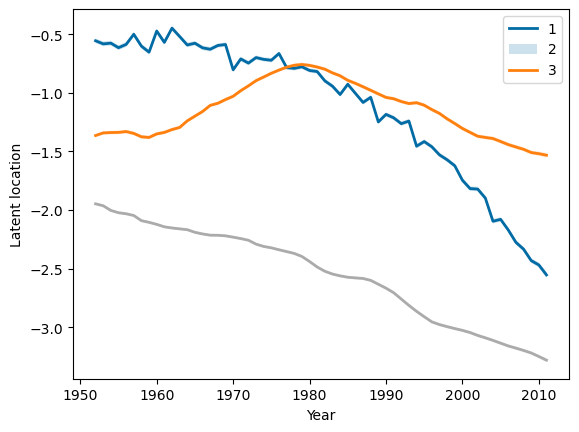

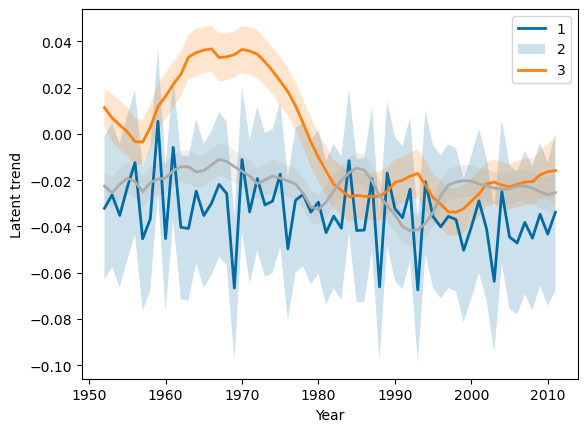

In [ ]:
plt.style.use('tableau-colorblind10')

level_loc = model.level_loc
level_scale = model.level_scale

trend_loc = model.trend_loc
trend_scale = model.trend_scale

fig, ax = plt.subplots()
for i in range(level_loc.shape[0]):
    ax.plot(range(param['first_year_train'],param['last_year_train']+1), level_loc[i], linewidth = 2)
    ax.fill_between(range(param['first_year_train'],param['last_year_train']+1), 
                    level_loc[i] - level_scale[i], 
                    level_loc[i] + level_scale[i], 
                    alpha = 0.2)

plt.xlabel ('Year')
plt.ylabel ('Latent location')
plt.gca().legend(('1','2','3'))

fig.savefig("../pics/latent_level.pdf", bbox_inches='tight', dpi=300)


fig, ax = plt.subplots()
for i in range(level_loc.shape[0]):
    ax.plot(range(param['first_year_train'],param['last_year_train']+1), trend_loc[i], linewidth = 2)
    ax.fill_between(range(param['first_year_train'],param['last_year_train']+1), 
                    trend_loc[i] - trend_scale[i], 
                    trend_loc[i] + trend_scale[i], 
                    alpha = 0.2)

plt.xlabel ('Year')
plt.ylabel ('Latent trend')
plt.gca().legend(('1','2','3'))

fig.savefig("../pics/" + model_string + "latent_trend.pdf", bbox_inches='tight', dpi=300)

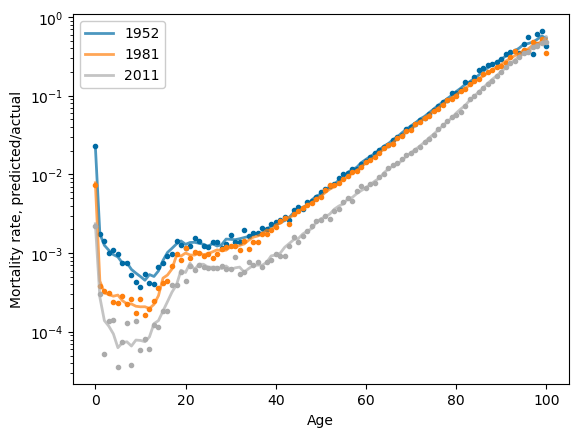

In [ ]:
plt.style.use('tableau-colorblind10')

ax = plt.gca()

times = [0,
         int((param['last_year_train'] - param['first_year_train'])/2),
         param['last_year_train'] - param['first_year_train']]

mc = model.mortality_curve

for time in times:
    color = next(ax._get_lines.prop_cycler)['color']
    plt.plot(mc(time), color = color, linewidth = 2, alpha = 0.7, label = '%d' % (param['first_year_train'] + time))
    plt.plot(deaths_train[time,:]/exposure_train[time,:],'.', color = color, alpha = 1.0)

plt.yscale('log')
plt.xlabel ('Age')
plt.ylabel ('Mortality rate, predicted/actual')
plt.legend(framealpha=1.0, frameon=True);

plt.savefig("../pics/" + model_string + "rateVsAge.pdf", bbox_inches='tight', dpi=300)

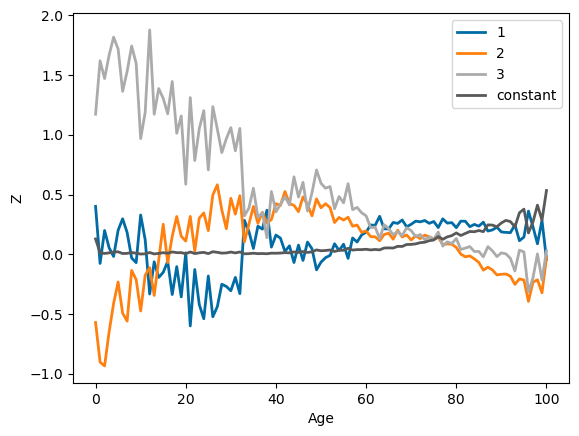

In [ ]:
for factor in model.factor_loadings[1:]:
    plt.plot(factor, linewidth = 2)
plt.plot(model.factor_loadings[0], linewidth = 2)

plt.xlabel ('Age')
plt.ylabel ('Z')
plt.gca().legend(('1','2','3','constant'))
plt.savefig("../pics/" + model_string + "loadings.pdf", bbox_inches='tight', dpi=300)


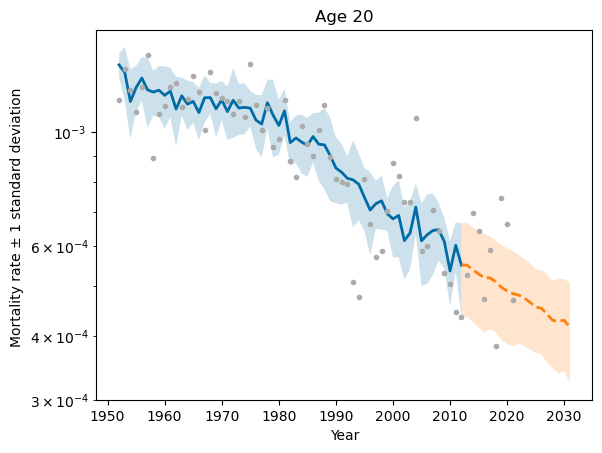

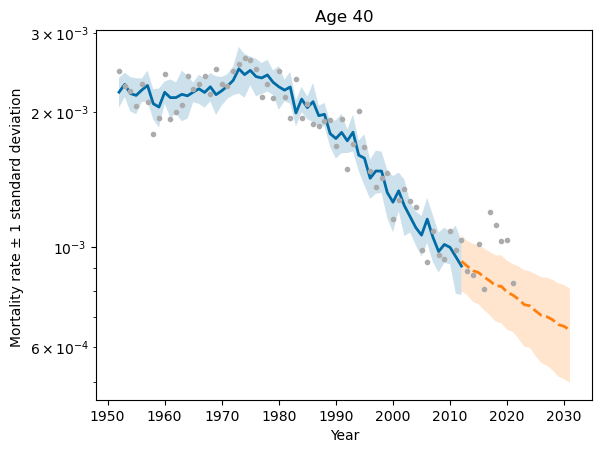

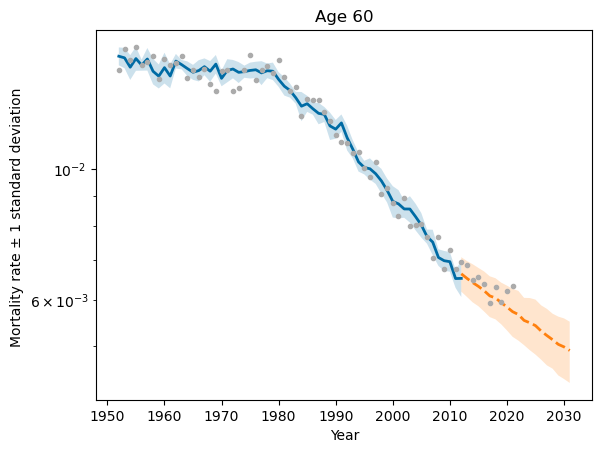

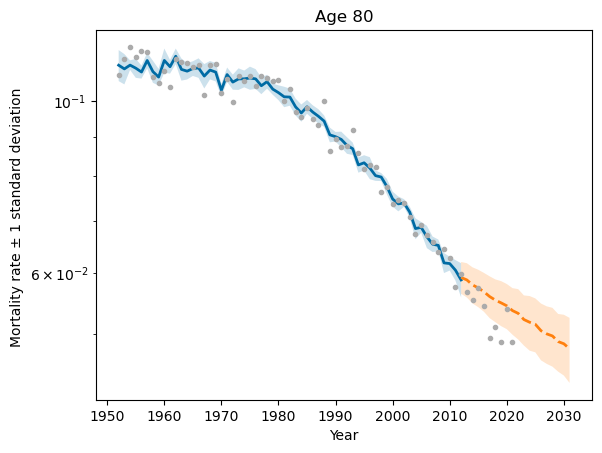

In [ ]:
ages = [20, 40, 60, 80]

forecast_length = 20
mc_samples = 10

for age in ages:

    mean, scale = model.mortality(age, mc_samples = mc_samples)
    mean_f, scale_f = model.forecast_mortality_rate(age = age, forecast_length = forecast_length, mc_samples = 1000)

    fig, ax = plt.subplots()

    ax.plot(
        range(param['first_year_train'], param['last_year_train'] + 2), 
        np.append(mean , mean_f[1]), 
        linewidth = 2
        )
    ax.plot(
        range(param['last_year_train'] +1 , 
              param['last_year_train'] + forecast_length + 1), 
              mean_f, '--', 
              linewidth = 2
              )
    ax.fill_between(
        range(param['first_year_train'], param['last_year_train'] + 2), 
        np.append(mean , mean_f[1]) - np.append(scale , scale_f[1]), 
        np.append(mean , mean_f[1]) + np.append(scale , scale_f[1]), 
        alpha=0.2
        )
    ax.fill_between(
        range(param['last_year_train'] +1 , 
              param['last_year_train'] + forecast_length + 1), 
              mean_f - scale_f, 
              mean_f + scale_f, 
              alpha=0.2
              )
    ax.plot(
        range(param['first_year_train'], 
              param['last_year_test'] + 1), 
              deaths_all[:,age]/exposure_all[:,age],
              '.'
              )

    plt.title("Age " + str(age))
    plt.yscale('log')
    plt.xlabel ('Year')
    plt.ylabel ('Mortality rate ± 1 standard deviation ')
    fig.savefig("../pics/" + model_string + "rateVsTimeAge" + str(age) + ".png", bbox_inches='tight', dpi=300)
    

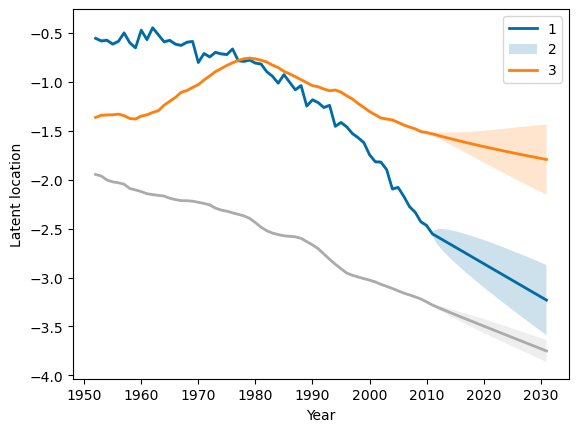

In [ ]:
(fcast_mean, fcast_scale) = model.forecast_factors(forecast_length = 20)

level = np.concatenate((model.level_loc, fcast_mean), axis = 1 )
scale = np.concatenate((model.level_scale, fcast_scale), axis = 1 )

fig, ax = plt.subplots()

for i in range(level.shape[0]):
    ax.plot(range(param['first_year_train'], param['last_year_train'] + forecast_length + 1), level[i], linewidth = 2)
    ax.fill_between(range(param['first_year_train'], param['last_year_train'] + forecast_length + 1), level[i] - scale[i], level[i] + scale[i], alpha=0.2)

plt.xlabel ('Year')
plt.ylabel ('Latent location')
plt.gca().legend(('1','2','3'))

fig.savefig("../pics/" + model_string + "latent_forecast.png", bbox_inches='tight', dpi=300)

In [ ]:
log_score = model.log_score(exposure_test, deaths_test, mc_samples = 1000)

In [ ]:
log_score


array([402.26825884, 410.48118514, 419.56420062, 422.8203197 ,
       441.83281195, 456.48998163, 437.00942885, 462.08107225,
       434.39734456, 437.63873412])

In [13]:
np.mean(log_score)

432.45833376380887

In [14]:
log_score_saturated = model.log_score_saturated(exposure_test, deaths_test)
log_score_saturated

array([338.88013777, 337.67787788, 336.63508868, 338.61017229,
       337.653797  , 338.69224085, 338.33413668, 336.08529658,
       340.80982805, 339.55357928])

In [15]:
np.mean(log_score_saturated)

338.29321550483553

In [16]:
log_score_naive = model.log_score_naive(exposure_test, deaths_test)
log_score_naive

array([ 448.83407137,  475.0055868 ,  521.31943572,  563.30052205,
        630.04417045,  750.5065556 ,  733.52725488, 1090.5280795 ,
        647.90473035, 1001.61098522])

In [17]:
np.mean(log_score_naive)

686.2581391958629